# Conformalized Early Stopping -- Regression

- We implement the conformalized early stopping algorithm as well as the benchmark methods on the bike sharing demand dataset provided by Hadi Fanaee Tork from Capital Bikeshare and hosted by the UCI Machine Learning Repository [1]. 

**Note: the following dataset description is copied from UCI Machine Learning Repository. **
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

- We follow the data cleaning process and used the same model architecture as in the conformalized quantile regression experiments https://github.com/yromano/cqr/tree/master/datasets [2]. To be specific, we standardize the features to have zero mean and unit variance and we rescale the response by dividing it by its mean absolute value

- For the benchmark methods, we randomly selected 2000 samples for training the deep neural network models, 1000 validation samples to decide the early stopped models, and additional 1000 samples for calibration. For the conformalized early stopping method, we use the same subset of selected samples but merge the training and validation samples and use the merged dataset for training. The 1000 calibration samples are used together with new test point to select the best models. For both benchmark and our proposed method, we train the model for  𝑇max=200  epochs, saving every snapshot, and compute the marginal coverage rate and size of the prediction intervals averaged over 100 test samples.

[1] Fanaee-T, Hadi, and Gama, Joao, Event labeling combining ensemble detectors and background knowledge, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

[2] Yaniv Romano, Evan Patterson, Emmanuel J. Candès, Conformalized Quantile Regression, Advances in Neural Information Processing Systems (2019), https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
sys.path.append('../third_party')

In [5]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt

from ConformalizedES.method import CES_regression
from ConformalizedES.networks import mse_model, MSE_loss
from ConformalizedES.inference import Conformal_PI
from third_party.coverage import *

In [6]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

## Loading and cleaning the dataset

In [7]:
reload_dataset = True

In [8]:
if reload_dataset:
  !git clone https://github.com/yromano/cqr.git

Cloning into 'cqr'...


In [9]:
from cqr.datasets import datasets

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


## The benchmark method

In [10]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 566
np.random.seed(seed)
th.manual_seed(seed)

idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]

# load the data
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split the dataset into disjoint subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# scale the response values by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM): train (2000, 18), validation (1000, 18), calibration (1000, 18), test (100, 18)


In [11]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [12]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), validation (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(val_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (32), validation (15), calibration (1000), test (100)


In [14]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) # dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [15]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 9% 	 train_loss: 1.85  took: 0.11s
Epoch 1 of 200, 18% 	 train_loss: 1.31  took: 0.01s
Epoch 1 of 200, 28% 	 train_loss: 1.09  took: 0.03s
Epoch 1 of 200, 37% 	 train_loss: 0.88  took: 0.05s
Epoch 1 of 200, 46% 	 train_loss: 0.78  took: 0.03s
Epoch 1 of 200, 56% 	 train_loss: 0.90  took: 0.05s
Epoch 1 of 200, 65% 	 train_loss: 0.72  took: 0.03s
Epoch 1 of 200, 75% 	 train_loss: 0.81  took: 0.03s
Epoch 1 of 200, 84% 	 train_loss: 0.67  took: 0.04s
Epoch 1 of 200, 93% 	 train_loss: 0.61  took: 0.03s
val_loss = 0.64
Snapshot saved at epoch 1.
Epoch 2 of 200, 9% 	 train_loss: 0.63  took: 0.05s
Epoch 2 of 200, 18% 	 train_loss: 0.60  took: 0.02s
Epoch 2 of 200, 28% 	 train_loss: 0.61  took: 0.03s
Epoch 2 of 200, 37% 	 train_loss: 0.56  took: 0.02s
Epoch 2 of 200, 46% 	 train_loss: 0.47  took: 0.02s
Epoch 2 of 200, 56% 	 train_loss: 0.53  took: 0.03s
Epoch 2 of 200, 65% 	 train_loss: 0.42  took: 0.03s
Epoch 2 of 200, 75% 	 train_loss: 0.60  took: 0.01s
Epoch 2 of 200, 84% 	 t

val_loss = 0.39
Snapshot saved at epoch 15.
Epoch 16 of 200, 9% 	 train_loss: 0.33  took: 0.02s
Epoch 16 of 200, 18% 	 train_loss: 0.29  took: 0.02s
Epoch 16 of 200, 28% 	 train_loss: 0.35  took: 0.02s
Epoch 16 of 200, 37% 	 train_loss: 0.31  took: 0.02s
Epoch 16 of 200, 46% 	 train_loss: 0.26  took: 0.02s
Epoch 16 of 200, 56% 	 train_loss: 0.34  took: 0.02s
Epoch 16 of 200, 65% 	 train_loss: 0.23  took: 0.02s
Epoch 16 of 200, 75% 	 train_loss: 0.33  took: 0.02s
Epoch 16 of 200, 84% 	 train_loss: 0.24  took: 0.02s
Epoch 16 of 200, 93% 	 train_loss: 0.28  took: 0.02s
val_loss = 0.39
Snapshot saved at epoch 16.
Epoch 17 of 200, 9% 	 train_loss: 0.32  took: 0.02s
Epoch 17 of 200, 18% 	 train_loss: 0.28  took: 0.02s
Epoch 17 of 200, 28% 	 train_loss: 0.34  took: 0.02s
Epoch 17 of 200, 37% 	 train_loss: 0.30  took: 0.02s
Epoch 17 of 200, 46% 	 train_loss: 0.25  took: 0.02s
Epoch 17 of 200, 56% 	 train_loss: 0.33  took: 0.02s
Epoch 17 of 200, 65% 	 train_loss: 0.22  took: 0.02s
Epoch 17 of 2

Epoch 30 of 200, 56% 	 train_loss: 0.22  took: 0.03s
Epoch 30 of 200, 65% 	 train_loss: 0.15  took: 0.03s
Epoch 30 of 200, 75% 	 train_loss: 0.24  took: 0.04s
Epoch 30 of 200, 84% 	 train_loss: 0.16  took: 0.03s
Epoch 30 of 200, 93% 	 train_loss: 0.21  took: 0.03s
val_loss = 0.33
Snapshot saved at epoch 30.
Epoch 31 of 200, 9% 	 train_loss: 0.23  took: 0.03s
Epoch 31 of 200, 18% 	 train_loss: 0.20  took: 0.03s
Epoch 31 of 200, 28% 	 train_loss: 0.24  took: 0.03s
Epoch 31 of 200, 37% 	 train_loss: 0.23  took: 0.03s
Epoch 31 of 200, 46% 	 train_loss: 0.19  took: 0.03s
Epoch 31 of 200, 56% 	 train_loss: 0.22  took: 0.02s
Epoch 31 of 200, 65% 	 train_loss: 0.14  took: 0.03s
Epoch 31 of 200, 75% 	 train_loss: 0.24  took: 0.02s
Epoch 31 of 200, 84% 	 train_loss: 0.16  took: 0.02s
Epoch 31 of 200, 93% 	 train_loss: 0.21  took: 0.02s
val_loss = 0.32
Snapshot saved at epoch 31.
Epoch 32 of 200, 9% 	 train_loss: 0.22  took: 0.02s
Epoch 32 of 200, 18% 	 train_loss: 0.20  took: 0.02s
Epoch 32 of 2

val_loss = 0.28
Snapshot saved at epoch 44.
Epoch 45 of 200, 9% 	 train_loss: 0.15  took: 0.04s
Epoch 45 of 200, 18% 	 train_loss: 0.15  took: 0.03s
Epoch 45 of 200, 28% 	 train_loss: 0.17  took: 0.03s
Epoch 45 of 200, 37% 	 train_loss: 0.16  took: 0.03s
Epoch 45 of 200, 46% 	 train_loss: 0.13  took: 0.02s
Epoch 45 of 200, 56% 	 train_loss: 0.14  took: 0.03s
Epoch 45 of 200, 65% 	 train_loss: 0.10  took: 0.04s
Epoch 45 of 200, 75% 	 train_loss: 0.15  took: 0.03s
Epoch 45 of 200, 84% 	 train_loss: 0.11  took: 0.04s
Epoch 45 of 200, 93% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.28
Snapshot saved at epoch 45.
Epoch 46 of 200, 9% 	 train_loss: 0.15  took: 0.03s
Epoch 46 of 200, 18% 	 train_loss: 0.14  took: 0.02s
Epoch 46 of 200, 28% 	 train_loss: 0.17  took: 0.04s
Epoch 46 of 200, 37% 	 train_loss: 0.16  took: 0.04s
Epoch 46 of 200, 46% 	 train_loss: 0.13  took: 0.03s
Epoch 46 of 200, 56% 	 train_loss: 0.13  took: 0.04s
Epoch 46 of 200, 65% 	 train_loss: 0.09  took: 0.03s
Epoch 46 of 2

Epoch 59 of 200, 46% 	 train_loss: 0.09  took: 0.03s
Epoch 59 of 200, 56% 	 train_loss: 0.08  took: 0.02s
Epoch 59 of 200, 65% 	 train_loss: 0.07  took: 0.02s
Epoch 59 of 200, 75% 	 train_loss: 0.10  took: 0.03s
Epoch 59 of 200, 84% 	 train_loss: 0.08  took: 0.03s
Epoch 59 of 200, 93% 	 train_loss: 0.10  took: 0.03s
val_loss = 0.25
Snapshot saved at epoch 59.
Epoch 60 of 200, 9% 	 train_loss: 0.09  took: 0.04s
Epoch 60 of 200, 18% 	 train_loss: 0.09  took: 0.03s
Epoch 60 of 200, 28% 	 train_loss: 0.12  took: 0.02s
Epoch 60 of 200, 37% 	 train_loss: 0.12  took: 0.03s
Epoch 60 of 200, 46% 	 train_loss: 0.09  took: 0.03s
Epoch 60 of 200, 56% 	 train_loss: 0.08  took: 0.03s
Epoch 60 of 200, 65% 	 train_loss: 0.07  took: 0.03s
Epoch 60 of 200, 75% 	 train_loss: 0.10  took: 0.02s
Epoch 60 of 200, 84% 	 train_loss: 0.08  took: 0.03s
Epoch 60 of 200, 93% 	 train_loss: 0.10  took: 0.02s
val_loss = 0.25
Snapshot saved at epoch 60.
Epoch 61 of 200, 9% 	 train_loss: 0.09  took: 0.03s
Epoch 61 of 2

Epoch 74 of 200, 9% 	 train_loss: 0.07  took: 0.03s
Epoch 74 of 200, 18% 	 train_loss: 0.06  took: 0.03s
Epoch 74 of 200, 28% 	 train_loss: 0.09  took: 0.03s
Epoch 74 of 200, 37% 	 train_loss: 0.09  took: 0.02s
Epoch 74 of 200, 46% 	 train_loss: 0.06  took: 0.03s
Epoch 74 of 200, 56% 	 train_loss: 0.05  took: 0.03s
Epoch 74 of 200, 65% 	 train_loss: 0.05  took: 0.03s
Epoch 74 of 200, 75% 	 train_loss: 0.07  took: 0.03s
Epoch 74 of 200, 84% 	 train_loss: 0.05  took: 0.02s
Epoch 74 of 200, 93% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.22
Snapshot saved at epoch 74.
Epoch 75 of 200, 9% 	 train_loss: 0.06  took: 0.02s
Epoch 75 of 200, 18% 	 train_loss: 0.06  took: 0.03s
Epoch 75 of 200, 28% 	 train_loss: 0.09  took: 0.03s
Epoch 75 of 200, 37% 	 train_loss: 0.08  took: 0.02s
Epoch 75 of 200, 46% 	 train_loss: 0.06  took: 0.03s
Epoch 75 of 200, 56% 	 train_loss: 0.05  took: 0.02s
Epoch 75 of 200, 65% 	 train_loss: 0.05  took: 0.02s
Epoch 75 of 200, 75% 	 train_loss: 0.06  took: 0.02s
Epoc

Epoch 88 of 200, 93% 	 train_loss: 0.05  took: 0.02s
val_loss = 0.21
Snapshot saved at epoch 88.
Epoch 89 of 200, 9% 	 train_loss: 0.05  took: 0.03s
Epoch 89 of 200, 18% 	 train_loss: 0.04  took: 0.03s
Epoch 89 of 200, 28% 	 train_loss: 0.07  took: 0.01s
Epoch 89 of 200, 37% 	 train_loss: 0.07  took: 0.05s
Epoch 89 of 200, 46% 	 train_loss: 0.05  took: 0.03s
Epoch 89 of 200, 56% 	 train_loss: 0.04  took: 0.02s
Epoch 89 of 200, 65% 	 train_loss: 0.04  took: 0.03s
Epoch 89 of 200, 75% 	 train_loss: 0.05  took: 0.03s
Epoch 89 of 200, 84% 	 train_loss: 0.04  took: 0.03s
Epoch 89 of 200, 93% 	 train_loss: 0.05  took: 0.03s
val_loss = 0.21
Snapshot saved at epoch 89.
Epoch 90 of 200, 9% 	 train_loss: 0.05  took: 0.02s
Epoch 90 of 200, 18% 	 train_loss: 0.04  took: 0.02s
Epoch 90 of 200, 28% 	 train_loss: 0.07  took: 0.02s
Epoch 90 of 200, 37% 	 train_loss: 0.06  took: 0.03s
Epoch 90 of 200, 46% 	 train_loss: 0.05  took: 0.02s
Epoch 90 of 200, 56% 	 train_loss: 0.04  took: 0.03s
Epoch 90 of 2

Epoch 103 of 200, 75% 	 train_loss: 0.04  took: 0.04s
Epoch 103 of 200, 84% 	 train_loss: 0.03  took: 0.02s
Epoch 103 of 200, 93% 	 train_loss: 0.04  took: 0.02s
val_loss = 0.20
Snapshot saved at epoch 103.
Epoch 104 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 104 of 200, 18% 	 train_loss: 0.03  took: 0.02s
Epoch 104 of 200, 28% 	 train_loss: 0.06  took: 0.02s
Epoch 104 of 200, 37% 	 train_loss: 0.05  took: 0.03s
Epoch 104 of 200, 46% 	 train_loss: 0.04  took: 0.04s
Epoch 104 of 200, 56% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 65% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 75% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 84% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 93% 	 train_loss: 0.04  took: 0.03s
val_loss = 0.20
Snapshot saved at epoch 104.
Epoch 105 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 105 of 200, 18% 	 train_loss: 0.03  took: 0.03s
Epoch 105 of 200, 28% 	 train_loss: 0.05  took: 0.03s
Epoch 105 of 200, 37% 	 train_loss: 0.05  took: 

Epoch 117 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.19
Snapshot saved at epoch 117.
Epoch 118 of 200, 9% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 18% 	 train_loss: 0.02  took: 0.03s
Epoch 118 of 200, 28% 	 train_loss: 0.04  took: 0.03s
Epoch 118 of 200, 37% 	 train_loss: 0.04  took: 0.02s
Epoch 118 of 200, 46% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 56% 	 train_loss: 0.02  took: 0.02s
Epoch 118 of 200, 65% 	 train_loss: 0.03  took: 0.02s
Epoch 118 of 200, 75% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 84% 	 train_loss: 0.02  took: 0.03s
Epoch 118 of 200, 93% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.19
Snapshot saved at epoch 118.
Epoch 119 of 200, 9% 	 train_loss: 0.03  took: 0.03s
Epoch 119 of 200, 18% 	 train_loss: 0.02  took: 0.02s
Epoch 119 of 200, 28% 	 train_loss: 0.04  took: 0.02s
Epoch 119 of 200, 37% 	 train_loss: 0.04  took: 0.03s
Epoch 119 of 200, 46% 	 train_loss: 0.03  took: 0.02s
Epoch 119 of 200, 56% 	 train_loss: 0.02  took: 

Epoch 132 of 200, 46% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 56% 	 train_loss: 0.02  took: 0.03s
Epoch 132 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 132 of 200, 75% 	 train_loss: 0.02  took: 0.02s
Epoch 132 of 200, 84% 	 train_loss: 0.02  took: 0.02s
Epoch 132 of 200, 93% 	 train_loss: 0.02  took: 0.02s
val_loss = 0.19
Snapshot saved at epoch 132.
Epoch 133 of 200, 9% 	 train_loss: 0.02  took: 0.03s
Epoch 133 of 200, 18% 	 train_loss: 0.02  took: 0.02s
Epoch 133 of 200, 28% 	 train_loss: 0.03  took: 0.02s
Epoch 133 of 200, 37% 	 train_loss: 0.03  took: 0.01s
Epoch 133 of 200, 46% 	 train_loss: 0.03  took: 0.03s
Epoch 133 of 200, 56% 	 train_loss: 0.02  took: 0.02s
Epoch 133 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 133 of 200, 75% 	 train_loss: 0.02  took: 0.03s
Epoch 133 of 200, 84% 	 train_loss: 0.02  took: 0.02s
Epoch 133 of 200, 93% 	 train_loss: 0.02  took: 0.03s
val_loss = 0.19
Snapshot saved at epoch 133.
Epoch 134 of 200, 9% 	 train_loss: 0.02  took: 

Epoch 147 of 200, 18% 	 train_loss: 0.03  took: 0.02s
Epoch 147 of 200, 28% 	 train_loss: 0.03  took: 0.03s
Epoch 147 of 200, 37% 	 train_loss: 0.03  took: 0.02s
Epoch 147 of 200, 46% 	 train_loss: 0.03  took: 0.02s
Epoch 147 of 200, 56% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 147 of 200, 75% 	 train_loss: 0.02  took: 0.02s
Epoch 147 of 200, 84% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 93% 	 train_loss: 0.02  took: 0.02s
val_loss = 0.20
Snapshot saved at epoch 147.
Epoch 148 of 200, 9% 	 train_loss: 0.02  took: 0.03s
Epoch 148 of 200, 18% 	 train_loss: 0.03  took: 0.02s
Epoch 148 of 200, 28% 	 train_loss: 0.03  took: 0.02s
Epoch 148 of 200, 37% 	 train_loss: 0.04  took: 0.02s
Epoch 148 of 200, 46% 	 train_loss: 0.03  took: 0.02s
Epoch 148 of 200, 56% 	 train_loss: 0.02  took: 0.03s
Epoch 148 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 148 of 200, 75% 	 train_loss: 0.02  took: 0.02s
Epoch 148 of 200, 84% 	 train_loss: 0.

Epoch 161 of 200, 56% 	 train_loss: 0.02  took: 0.02s
Epoch 161 of 200, 65% 	 train_loss: 0.02  took: 0.03s
Epoch 161 of 200, 75% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 84% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.20
Snapshot saved at epoch 161.
Epoch 162 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 162 of 200, 18% 	 train_loss: 0.02  took: 0.02s
Epoch 162 of 200, 28% 	 train_loss: 0.05  took: 0.03s
Epoch 162 of 200, 37% 	 train_loss: 0.03  took: 0.02s
Epoch 162 of 200, 46% 	 train_loss: 0.03  took: 0.02s
Epoch 162 of 200, 56% 	 train_loss: 0.02  took: 0.02s
Epoch 162 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 162 of 200, 75% 	 train_loss: 0.03  took: 0.02s
Epoch 162 of 200, 84% 	 train_loss: 0.03  took: 0.03s
Epoch 162 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.21
Snapshot saved at epoch 162.
Epoch 163 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 163 of 200, 18% 	 train_loss: 0.02  took: 

Epoch 175 of 200, 56% 	 train_loss: 0.02  took: 0.03s
Epoch 175 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 175 of 200, 75% 	 train_loss: 0.02  took: 0.02s
Epoch 175 of 200, 84% 	 train_loss: 0.03  took: 0.02s
Epoch 175 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.22
Snapshot saved at epoch 175.
Epoch 176 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 176 of 200, 18% 	 train_loss: 0.02  took: 0.02s
Epoch 176 of 200, 28% 	 train_loss: 0.04  took: 0.03s
Epoch 176 of 200, 37% 	 train_loss: 0.03  took: 0.02s
Epoch 176 of 200, 46% 	 train_loss: 0.02  took: 0.02s
Epoch 176 of 200, 56% 	 train_loss: 0.02  took: 0.02s
Epoch 176 of 200, 65% 	 train_loss: 0.02  took: 0.02s
Epoch 176 of 200, 75% 	 train_loss: 0.02  took: 0.02s
Epoch 176 of 200, 84% 	 train_loss: 0.03  took: 0.03s
Epoch 176 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.22
Snapshot saved at epoch 176.
Epoch 177 of 200, 9% 	 train_loss: 0.03  took: 0.03s
Epoch 177 of 200, 18% 	 train_loss: 0.02  took: 

Epoch 189 of 200, 84% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 93% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.24
Snapshot saved at epoch 189.
Epoch 190 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 190 of 200, 18% 	 train_loss: 0.02  took: 0.03s
Epoch 190 of 200, 28% 	 train_loss: 0.04  took: 0.02s
Epoch 190 of 200, 37% 	 train_loss: 0.03  took: 0.03s
Epoch 190 of 200, 46% 	 train_loss: 0.02  took: 0.02s
Epoch 190 of 200, 56% 	 train_loss: 0.03  took: 0.02s
Epoch 190 of 200, 65% 	 train_loss: 0.02  took: 0.03s
Epoch 190 of 200, 75% 	 train_loss: 0.02  took: 0.01s
Epoch 190 of 200, 84% 	 train_loss: 0.03  took: 0.02s
Epoch 190 of 200, 93% 	 train_loss: 0.03  took: 0.01s
val_loss = 0.25
Snapshot saved at epoch 190.
Epoch 191 of 200, 9% 	 train_loss: 0.04  took: 0.02s
Epoch 191 of 200, 18% 	 train_loss: 0.02  took: 0.02s
Epoch 191 of 200, 28% 	 train_loss: 0.04  took: 0.03s
Epoch 191 of 200, 37% 	 train_loss: 0.03  took: 0.02s
Epoch 191 of 200, 46% 	 train_loss: 0.02  took: 

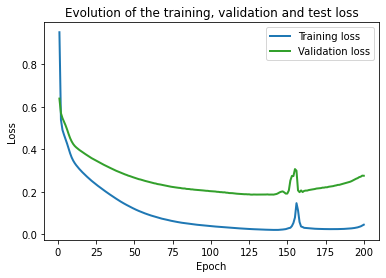

In [16]:
# plot the loss history
plot_loss(BM_reg.train_loss_history, BM_reg.val_loss_history)

In [17]:
# Check the benchmark models
bm_loss, bm_model, loss_history = BM_reg.select_model()

0.18717103600502014
./content\model127.pth


In [18]:
# Split conformal prediction 
alpha = 0.1

coverage_BM = []
size_BM = []
test_losses_BM = []
pi_BM = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model)
  pi_BM.append(benchmarkPI[0])
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg.net.load_state_dict(torch.load(bm_model, map_location=device))
  test_loss = BM_reg.get_loss(input, response)
  test_losses_BM.append(test_loss)

wsc_coverages_BM = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM, M=100, delta = 0.1)
  wsc_coverages_BM.append(wsc_coverage)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]
C:\Users\16266\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\16266\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The conditional coverage rate is (BM) {}".format(sum(wsc_coverages_BM)/len(wsc_coverages_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))
print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))

The marginal coverage rate is (BM) 0.93
The conditional coverage rate is (BM) nan
The average size is (BM) 1.42608430504799
The test loss is (BM) 0.14069892466068268


## Conforamlized early stopping

In [20]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_CES, idx_cal_CES = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_CES])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_CES]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_CES, y_train_CES = X_train[idx_train_CES], y_train[idx_train_CES]
X_cal_CES, y_cal_CES = X_train[idx_cal_CES], y_train[idx_cal_CES]

print("Size (CES): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_CES.shape[0], X_train_CES.shape[1], X_cal_CES.shape[0], X_cal_CES.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (CES): train (3000, 18), calibration (1000, 18), test (100, 18)


In [21]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_CES.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5
num_workers = 0

In [22]:
train_loader = DataLoader(PrepareData(X_train_CES, y_train_CES, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_CES, y_cal_CES, scale_X=False), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (15), test (100)


In [23]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

CES_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [24]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.54  took: 0.03s
Epoch 1 of 200, 17% 	 train_loss: 1.20  took: 0.03s
Epoch 1 of 200, 25% 	 train_loss: 0.94  took: 0.06s
Epoch 1 of 200, 34% 	 train_loss: 0.89  took: 0.04s
Epoch 1 of 200, 42% 	 train_loss: 0.85  took: 0.06s
Epoch 1 of 200, 51% 	 train_loss: 0.78  took: 0.04s
Epoch 1 of 200, 59% 	 train_loss: 0.75  took: 0.04s
Epoch 1 of 200, 68% 	 train_loss: 0.80  took: 0.06s
Epoch 1 of 200, 76% 	 train_loss: 0.55  took: 0.05s
Epoch 1 of 200, 85% 	 train_loss: 0.51  took: 0.05s
Epoch 1 of 200, 93% 	 train_loss: 0.64  took: 0.04s
val_loss = 0.56
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.60  took: 0.05s
Epoch 2 of 200, 17% 	 train_loss: 0.63  took: 0.03s
Epoch 2 of 200, 25% 	 train_loss: 0.56  took: 0.05s
Epoch 2 of 200, 34% 	 train_loss: 0.56  took: 0.04s
Epoch 2 of 200, 42% 	 train_loss: 0.55  took: 0.03s
Epoch 2 of 200, 51% 	 train_loss: 0.52  took: 0.03s
Epoch 2 of 200, 59% 	 train_loss: 0.56  took: 0.06s
Epoch 2 of 200, 68% 	 t

Epoch 14 of 200, 76% 	 train_loss: 0.24  took: 0.02s
Epoch 14 of 200, 85% 	 train_loss: 0.23  took: 0.03s
Epoch 14 of 200, 93% 	 train_loss: 0.36  took: 0.05s
val_loss = 0.34
Snapshot saved at epoch 14.
Epoch 15 of 200, 8% 	 train_loss: 0.26  took: 0.03s
Epoch 15 of 200, 17% 	 train_loss: 0.37  took: 0.04s
Epoch 15 of 200, 25% 	 train_loss: 0.30  took: 0.03s
Epoch 15 of 200, 34% 	 train_loss: 0.26  took: 0.03s
Epoch 15 of 200, 42% 	 train_loss: 0.26  took: 0.03s
Epoch 15 of 200, 51% 	 train_loss: 0.34  took: 0.05s
Epoch 15 of 200, 59% 	 train_loss: 0.30  took: 0.03s
Epoch 15 of 200, 68% 	 train_loss: 0.33  took: 0.05s
Epoch 15 of 200, 76% 	 train_loss: 0.23  took: 0.05s
Epoch 15 of 200, 85% 	 train_loss: 0.22  took: 0.04s
Epoch 15 of 200, 93% 	 train_loss: 0.35  took: 0.03s
val_loss = 0.33
Snapshot saved at epoch 15.
Epoch 16 of 200, 8% 	 train_loss: 0.25  took: 0.03s
Epoch 16 of 200, 17% 	 train_loss: 0.36  took: 0.03s
Epoch 16 of 200, 25% 	 train_loss: 0.29  took: 0.03s
Epoch 16 of 2

val_loss = 0.27
Snapshot saved at epoch 27.
Epoch 28 of 200, 8% 	 train_loss: 0.17  took: 0.04s
Epoch 28 of 200, 17% 	 train_loss: 0.27  took: 0.04s
Epoch 28 of 200, 25% 	 train_loss: 0.22  took: 0.03s
Epoch 28 of 200, 34% 	 train_loss: 0.19  took: 0.03s
Epoch 28 of 200, 42% 	 train_loss: 0.17  took: 0.03s
Epoch 28 of 200, 51% 	 train_loss: 0.25  took: 0.03s
Epoch 28 of 200, 59% 	 train_loss: 0.19  took: 0.03s
Epoch 28 of 200, 68% 	 train_loss: 0.22  took: 0.03s
Epoch 28 of 200, 76% 	 train_loss: 0.15  took: 0.02s
Epoch 28 of 200, 85% 	 train_loss: 0.16  took: 0.03s
Epoch 28 of 200, 93% 	 train_loss: 0.23  took: 0.03s
val_loss = 0.26
Snapshot saved at epoch 28.
Epoch 29 of 200, 8% 	 train_loss: 0.17  took: 0.05s
Epoch 29 of 200, 17% 	 train_loss: 0.26  took: 0.05s
Epoch 29 of 200, 25% 	 train_loss: 0.21  took: 0.05s
Epoch 29 of 200, 34% 	 train_loss: 0.18  took: 0.04s
Epoch 29 of 200, 42% 	 train_loss: 0.16  took: 0.04s
Epoch 29 of 200, 51% 	 train_loss: 0.24  took: 0.04s
Epoch 29 of 2

Epoch 41 of 200, 25% 	 train_loss: 0.14  took: 0.03s
Epoch 41 of 200, 34% 	 train_loss: 0.13  took: 0.03s
Epoch 41 of 200, 42% 	 train_loss: 0.11  took: 0.03s
Epoch 41 of 200, 51% 	 train_loss: 0.17  took: 0.02s
Epoch 41 of 200, 59% 	 train_loss: 0.12  took: 0.02s
Epoch 41 of 200, 68% 	 train_loss: 0.13  took: 0.02s
Epoch 41 of 200, 76% 	 train_loss: 0.09  took: 0.03s
Epoch 41 of 200, 85% 	 train_loss: 0.10  took: 0.02s
Epoch 41 of 200, 93% 	 train_loss: 0.14  took: 0.03s
val_loss = 0.20
Snapshot saved at epoch 41.
Epoch 42 of 200, 8% 	 train_loss: 0.11  took: 0.03s
Epoch 42 of 200, 17% 	 train_loss: 0.17  took: 0.02s
Epoch 42 of 200, 25% 	 train_loss: 0.13  took: 0.03s
Epoch 42 of 200, 34% 	 train_loss: 0.12  took: 0.03s
Epoch 42 of 200, 42% 	 train_loss: 0.10  took: 0.03s
Epoch 42 of 200, 51% 	 train_loss: 0.17  took: 0.02s
Epoch 42 of 200, 59% 	 train_loss: 0.11  took: 0.03s
Epoch 42 of 200, 68% 	 train_loss: 0.13  took: 0.03s
Epoch 42 of 200, 76% 	 train_loss: 0.09  took: 0.02s
Epo

Epoch 54 of 200, 68% 	 train_loss: 0.08  took: 0.05s
Epoch 54 of 200, 76% 	 train_loss: 0.06  took: 0.04s
Epoch 54 of 200, 85% 	 train_loss: 0.06  took: 0.03s
Epoch 54 of 200, 93% 	 train_loss: 0.09  took: 0.05s
val_loss = 0.16
Snapshot saved at epoch 54.
Epoch 55 of 200, 8% 	 train_loss: 0.07  took: 0.04s
Epoch 55 of 200, 17% 	 train_loss: 0.11  took: 0.04s
Epoch 55 of 200, 25% 	 train_loss: 0.08  took: 0.03s
Epoch 55 of 200, 34% 	 train_loss: 0.08  took: 0.04s
Epoch 55 of 200, 42% 	 train_loss: 0.07  took: 0.06s
Epoch 55 of 200, 51% 	 train_loss: 0.11  took: 0.05s
Epoch 55 of 200, 59% 	 train_loss: 0.07  took: 0.04s
Epoch 55 of 200, 68% 	 train_loss: 0.08  took: 0.04s
Epoch 55 of 200, 76% 	 train_loss: 0.06  took: 0.04s
Epoch 55 of 200, 85% 	 train_loss: 0.06  took: 0.05s
Epoch 55 of 200, 93% 	 train_loss: 0.09  took: 0.04s
val_loss = 0.16
Snapshot saved at epoch 55.
Epoch 56 of 200, 8% 	 train_loss: 0.07  took: 0.04s
Epoch 56 of 200, 17% 	 train_loss: 0.11  took: 0.04s
Epoch 56 of 2

Epoch 67 of 200, 85% 	 train_loss: 0.05  took: 0.04s
Epoch 67 of 200, 93% 	 train_loss: 0.06  took: 0.02s
val_loss = 0.14
Snapshot saved at epoch 67.
Epoch 68 of 200, 8% 	 train_loss: 0.05  took: 0.03s
Epoch 68 of 200, 17% 	 train_loss: 0.08  took: 0.04s
Epoch 68 of 200, 25% 	 train_loss: 0.05  took: 0.04s
Epoch 68 of 200, 34% 	 train_loss: 0.06  took: 0.05s
Epoch 68 of 200, 42% 	 train_loss: 0.05  took: 0.04s
Epoch 68 of 200, 51% 	 train_loss: 0.07  took: 0.05s
Epoch 68 of 200, 59% 	 train_loss: 0.06  took: 0.05s
Epoch 68 of 200, 68% 	 train_loss: 0.05  took: 0.04s
Epoch 68 of 200, 76% 	 train_loss: 0.04  took: 0.04s
Epoch 68 of 200, 85% 	 train_loss: 0.05  took: 0.06s
Epoch 68 of 200, 93% 	 train_loss: 0.06  took: 0.04s
val_loss = 0.14
Snapshot saved at epoch 68.
Epoch 69 of 200, 8% 	 train_loss: 0.05  took: 0.04s
Epoch 69 of 200, 17% 	 train_loss: 0.08  took: 0.04s
Epoch 69 of 200, 25% 	 train_loss: 0.05  took: 0.04s
Epoch 69 of 200, 34% 	 train_loss: 0.06  took: 0.03s
Epoch 69 of 2

Epoch 81 of 200, 17% 	 train_loss: 0.06  took: 0.03s
Epoch 81 of 200, 25% 	 train_loss: 0.04  took: 0.02s
Epoch 81 of 200, 34% 	 train_loss: 0.04  took: 0.02s
Epoch 81 of 200, 42% 	 train_loss: 0.03  took: 0.02s
Epoch 81 of 200, 51% 	 train_loss: 0.05  took: 0.03s
Epoch 81 of 200, 59% 	 train_loss: 0.04  took: 0.03s
Epoch 81 of 200, 68% 	 train_loss: 0.03  took: 0.02s
Epoch 81 of 200, 76% 	 train_loss: 0.03  took: 0.05s
Epoch 81 of 200, 85% 	 train_loss: 0.04  took: 0.04s
Epoch 81 of 200, 93% 	 train_loss: 0.04  took: 0.04s
val_loss = 0.13
Snapshot saved at epoch 81.
Epoch 82 of 200, 8% 	 train_loss: 0.04  took: 0.04s
Epoch 82 of 200, 17% 	 train_loss: 0.06  took: 0.04s
Epoch 82 of 200, 25% 	 train_loss: 0.04  took: 0.03s
Epoch 82 of 200, 34% 	 train_loss: 0.04  took: 0.03s
Epoch 82 of 200, 42% 	 train_loss: 0.03  took: 0.04s
Epoch 82 of 200, 51% 	 train_loss: 0.05  took: 0.04s
Epoch 82 of 200, 59% 	 train_loss: 0.04  took: 0.03s
Epoch 82 of 200, 68% 	 train_loss: 0.03  took: 0.04s
Epo

Epoch 94 of 200, 59% 	 train_loss: 0.03  took: 0.03s
Epoch 94 of 200, 68% 	 train_loss: 0.02  took: 0.04s
Epoch 94 of 200, 76% 	 train_loss: 0.02  took: 0.05s
Epoch 94 of 200, 85% 	 train_loss: 0.03  took: 0.05s
Epoch 94 of 200, 93% 	 train_loss: 0.03  took: 0.05s
val_loss = 0.12
Snapshot saved at epoch 94.
Epoch 95 of 200, 8% 	 train_loss: 0.03  took: 0.04s
Epoch 95 of 200, 17% 	 train_loss: 0.04  took: 0.05s
Epoch 95 of 200, 25% 	 train_loss: 0.03  took: 0.05s
Epoch 95 of 200, 34% 	 train_loss: 0.03  took: 0.02s
Epoch 95 of 200, 42% 	 train_loss: 0.02  took: 0.03s
Epoch 95 of 200, 51% 	 train_loss: 0.04  took: 0.04s
Epoch 95 of 200, 59% 	 train_loss: 0.03  took: 0.02s
Epoch 95 of 200, 68% 	 train_loss: 0.02  took: 0.05s
Epoch 95 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 95 of 200, 85% 	 train_loss: 0.03  took: 0.03s
Epoch 95 of 200, 93% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.12
Snapshot saved at epoch 95.
Epoch 96 of 200, 8% 	 train_loss: 0.03  took: 0.05s
Epoch 96 of 2

Epoch 107 of 200, 85% 	 train_loss: 0.03  took: 0.05s
Epoch 107 of 200, 93% 	 train_loss: 0.03  took: 0.04s
val_loss = 0.12
Snapshot saved at epoch 107.
Epoch 108 of 200, 8% 	 train_loss: 0.02  took: 0.03s
Epoch 108 of 200, 17% 	 train_loss: 0.03  took: 0.04s
Epoch 108 of 200, 25% 	 train_loss: 0.02  took: 0.03s
Epoch 108 of 200, 34% 	 train_loss: 0.03  took: 0.03s
Epoch 108 of 200, 42% 	 train_loss: 0.02  took: 0.03s
Epoch 108 of 200, 51% 	 train_loss: 0.03  took: 0.03s
Epoch 108 of 200, 59% 	 train_loss: 0.02  took: 0.04s
Epoch 108 of 200, 68% 	 train_loss: 0.02  took: 0.03s
Epoch 108 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 108 of 200, 85% 	 train_loss: 0.03  took: 0.03s
Epoch 108 of 200, 93% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.12
Snapshot saved at epoch 108.
Epoch 109 of 200, 8% 	 train_loss: 0.02  took: 0.03s
Epoch 109 of 200, 17% 	 train_loss: 0.03  took: 0.03s
Epoch 109 of 200, 25% 	 train_loss: 0.02  took: 0.03s
Epoch 109 of 200, 34% 	 train_loss: 0.03  took: 

Epoch 120 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 120 of 200, 85% 	 train_loss: 0.03  took: 0.03s
Epoch 120 of 200, 93% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.12
Snapshot saved at epoch 120.
Epoch 121 of 200, 8% 	 train_loss: 0.03  took: 0.03s
Epoch 121 of 200, 17% 	 train_loss: 0.03  took: 0.03s
Epoch 121 of 200, 25% 	 train_loss: 0.02  took: 0.03s
Epoch 121 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 121 of 200, 42% 	 train_loss: 0.02  took: 0.02s
Epoch 121 of 200, 51% 	 train_loss: 0.02  took: 0.03s
Epoch 121 of 200, 59% 	 train_loss: 0.03  took: 0.03s
Epoch 121 of 200, 68% 	 train_loss: 0.02  took: 0.03s
Epoch 121 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 121 of 200, 85% 	 train_loss: 0.03  took: 0.03s
Epoch 121 of 200, 93% 	 train_loss: 0.03  took: 0.05s
val_loss = 0.12
Snapshot saved at epoch 121.
Epoch 122 of 200, 8% 	 train_loss: 0.03  took: 0.05s
Epoch 122 of 200, 17% 	 train_loss: 0.03  took: 0.04s
Epoch 122 of 200, 25% 	 train_loss: 0.02  took: 

Epoch 133 of 200, 93% 	 train_loss: 0.02  took: 0.02s
val_loss = 0.12
Snapshot saved at epoch 133.
Epoch 134 of 200, 8% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 17% 	 train_loss: 0.03  took: 0.03s
Epoch 134 of 200, 25% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 34% 	 train_loss: 0.02  took: 0.03s
Epoch 134 of 200, 42% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 51% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 59% 	 train_loss: 0.02  took: 0.03s
Epoch 134 of 200, 68% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 134 of 200, 85% 	 train_loss: 0.02  took: 0.02s
Epoch 134 of 200, 93% 	 train_loss: 0.02  took: 0.02s
val_loss = 0.12
Snapshot saved at epoch 134.
Epoch 135 of 200, 8% 	 train_loss: 0.02  took: 0.02s
Epoch 135 of 200, 17% 	 train_loss: 0.03  took: 0.02s
Epoch 135 of 200, 25% 	 train_loss: 0.02  took: 0.02s
Epoch 135 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 135 of 200, 42% 	 train_loss: 0.02  took: 

Epoch 147 of 200, 8% 	 train_loss: 0.02  took: 0.04s
Epoch 147 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 25% 	 train_loss: 0.01  took: 0.02s
Epoch 147 of 200, 34% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 42% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 51% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 59% 	 train_loss: 0.02  took: 0.02s
Epoch 147 of 200, 68% 	 train_loss: 0.01  took: 0.03s
Epoch 147 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 85% 	 train_loss: 0.02  took: 0.03s
Epoch 147 of 200, 93% 	 train_loss: 0.02  took: 0.01s
val_loss = 0.12
Snapshot saved at epoch 147.
Epoch 148 of 200, 8% 	 train_loss: 0.02  took: 0.02s
Epoch 148 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 148 of 200, 25% 	 train_loss: 0.01  took: 0.03s
Epoch 148 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 148 of 200, 42% 	 train_loss: 0.02  took: 0.04s
Epoch 148 of 200, 51% 	 train_loss: 0.01  took: 0.03s
Epoch 148 of 200, 59% 	 train_loss: 0.0

Epoch 159 of 200, 85% 	 train_loss: 0.02  took: 0.02s
Epoch 159 of 200, 93% 	 train_loss: 0.02  took: 0.02s
val_loss = 0.12
Snapshot saved at epoch 159.
Epoch 160 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 160 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 160 of 200, 25% 	 train_loss: 0.01  took: 0.03s
Epoch 160 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 160 of 200, 42% 	 train_loss: 0.01  took: 0.04s
Epoch 160 of 200, 51% 	 train_loss: 0.01  took: 0.03s
Epoch 160 of 200, 59% 	 train_loss: 0.01  took: 0.05s
Epoch 160 of 200, 68% 	 train_loss: 0.01  took: 0.04s
Epoch 160 of 200, 76% 	 train_loss: 0.01  took: 0.05s
Epoch 160 of 200, 85% 	 train_loss: 0.02  took: 0.04s
Epoch 160 of 200, 93% 	 train_loss: 0.02  took: 0.04s
val_loss = 0.12
Snapshot saved at epoch 160.
Epoch 161 of 200, 8% 	 train_loss: 0.01  took: 0.04s
Epoch 161 of 200, 17% 	 train_loss: 0.02  took: 0.04s
Epoch 161 of 200, 25% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 34% 	 train_loss: 0.01  took: 

val_loss = 0.12
Snapshot saved at epoch 172.
Epoch 173 of 200, 8% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 173 of 200, 25% 	 train_loss: 0.01  took: 0.05s
Epoch 173 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 42% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 51% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 59% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 68% 	 train_loss: 0.01  took: 0.02s
Epoch 173 of 200, 76% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 85% 	 train_loss: 0.02  took: 0.05s
Epoch 173 of 200, 93% 	 train_loss: 0.02  took: 0.03s
val_loss = 0.12
Snapshot saved at epoch 173.
Epoch 174 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 25% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 42% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 51% 	 train_loss: 0.02  took: 

Epoch 186 of 200, 34% 	 train_loss: 0.04  took: 0.03s
Epoch 186 of 200, 42% 	 train_loss: 0.03  took: 0.02s
Epoch 186 of 200, 51% 	 train_loss: 0.03  took: 0.02s
Epoch 186 of 200, 59% 	 train_loss: 0.02  took: 0.03s
Epoch 186 of 200, 68% 	 train_loss: 0.02  took: 0.03s
Epoch 186 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 186 of 200, 85% 	 train_loss: 0.02  took: 0.03s
Epoch 186 of 200, 93% 	 train_loss: 0.02  took: 0.04s
val_loss = 0.11
Snapshot saved at epoch 186.
Epoch 187 of 200, 8% 	 train_loss: 0.02  took: 0.05s
Epoch 187 of 200, 17% 	 train_loss: 0.02  took: 0.05s
Epoch 187 of 200, 25% 	 train_loss: 0.02  took: 0.05s
Epoch 187 of 200, 34% 	 train_loss: 0.02  took: 0.04s
Epoch 187 of 200, 42% 	 train_loss: 0.02  took: 0.04s
Epoch 187 of 200, 51% 	 train_loss: 0.03  took: 0.03s
Epoch 187 of 200, 59% 	 train_loss: 0.03  took: 0.05s
Epoch 187 of 200, 68% 	 train_loss: 0.02  took: 0.05s
Epoch 187 of 200, 76% 	 train_loss: 0.02  took: 0.03s
Epoch 187 of 200, 85% 	 train_loss: 0.

Epoch 199 of 200, 59% 	 train_loss: 0.06  took: 0.03s
Epoch 199 of 200, 68% 	 train_loss: 0.06  took: 0.03s
Epoch 199 of 200, 76% 	 train_loss: 0.06  took: 0.02s
Epoch 199 of 200, 85% 	 train_loss: 0.06  took: 0.02s
Epoch 199 of 200, 93% 	 train_loss: 0.07  took: 0.03s
val_loss = 0.18
Snapshot saved at epoch 199.
Epoch 200 of 200, 8% 	 train_loss: 0.06  took: 0.02s
Epoch 200 of 200, 17% 	 train_loss: 0.07  took: 0.04s
Epoch 200 of 200, 25% 	 train_loss: 0.04  took: 0.03s
Epoch 200 of 200, 34% 	 train_loss: 0.05  took: 0.04s
Epoch 200 of 200, 42% 	 train_loss: 0.05  took: 0.03s
Epoch 200 of 200, 51% 	 train_loss: 0.06  took: 0.03s
Epoch 200 of 200, 59% 	 train_loss: 0.07  took: 0.03s
Epoch 200 of 200, 68% 	 train_loss: 0.09  took: 0.04s
Epoch 200 of 200, 76% 	 train_loss: 0.05  took: 0.02s
Epoch 200 of 200, 85% 	 train_loss: 0.08  took: 0.03s
Epoch 200 of 200, 93% 	 train_loss: 0.08  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 200.
Training done! A list of 200 models saved.


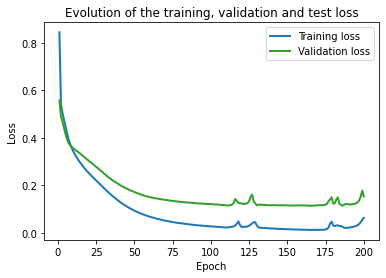

In [25]:
plot_loss(CES_reg.train_loss_history, CES_reg.val_loss_history)

In [26]:
# allowing empty intervals
alpha = 0.1

coverage_CES = []
size_CES = []
test_losses_CES = []
pi_CES = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # do ICP using the best models
  CESPI = C_PI.CES_icp(input, best_models, method = 'union')
  pi_CES.append(CESPI)
  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  coverage_CES.append(coverage_single)
  size_CES.append(size_single)
  # pdb.set_trace()

wsc_coverages_CES = []
for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_CES, M=100, delta = 0.1)
  wsc_coverages_CES.append(wsc_coverage)

print("The marginal coverage rate is (CES) {}".format(sum(coverage_CES)/len(coverage_CES)))
print("The conditional coverage rate is (CES) {}".format(sum(wsc_coverages_CES)/len(wsc_coverages_CES)))
print("The average size is (CES) {}".format(sum(size_CES)/len(size_CES)))
# print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))
print("The validation loss is (CES) {}".format(np.mean(CES_reg.val_loss_history[-20:])))


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

elapse time (selecting best models):37.71632528305054


  1%|▊                                                                               | 1/100 [00:38<1:02:45, 38.03s/it]

elapse time (selecting best models):42.02712297439575


  2%|█▌                                                                              | 2/100 [01:20<1:06:19, 40.61s/it]

elapse time (selecting best models):40.67431092262268


  3%|██▍                                                                             | 3/100 [02:01<1:05:53, 40.76s/it]

elapse time (selecting best models):42.00020670890808


  4%|███▏                                                                            | 4/100 [02:43<1:06:11, 41.37s/it]

elapse time (selecting best models):41.45204544067383


  5%|████                                                                            | 5/100 [03:25<1:05:46, 41.54s/it]

elapse time (selecting best models):40.91078853607178


  6%|████▊                                                                           | 6/100 [04:06<1:04:51, 41.40s/it]

elapse time (selecting best models):35.624733686447144


  7%|█████▌                                                                          | 7/100 [04:42<1:01:25, 39.63s/it]

elapse time (selecting best models):41.78390192985535


  8%|██████▍                                                                         | 8/100 [05:24<1:01:58, 40.42s/it]

elapse time (selecting best models):42.60423707962036


  9%|███████▏                                                                        | 9/100 [06:07<1:02:27, 41.18s/it]

elapse time (selecting best models):40.65053462982178


 10%|███████▉                                                                       | 10/100 [06:48<1:01:47, 41.19s/it]

elapse time (selecting best models):43.383203983306885


 11%|████████▋                                                                      | 11/100 [07:32<1:02:14, 41.96s/it]

elapse time (selecting best models):49.11132502555847


 12%|█████████▍                                                                     | 12/100 [08:21<1:04:52, 44.23s/it]

elapse time (selecting best models):40.072885513305664


 13%|██████████▎                                                                    | 13/100 [09:02<1:02:29, 43.10s/it]

elapse time (selecting best models):44.18873190879822


 14%|███████████                                                                    | 14/100 [09:47<1:02:27, 43.58s/it]

elapse time (selecting best models):39.7241370677948


 16%|████████████▋                                                                  | 16/100 [11:24<1:05:37, 46.87s/it]

elapse time (selecting best models):56.92546081542969
elapse time (selecting best models):42.124417781829834


 17%|█████████████▍                                                                 | 17/100 [12:06<1:03:00, 45.55s/it]

elapse time (selecting best models):37.25772500038147


 18%|██████████████▌                                                                  | 18/100 [12:44<58:58, 43.15s/it]

elapse time (selecting best models):45.1740460395813


 19%|███████████████▍                                                                 | 19/100 [13:29<59:14, 43.88s/it]

elapse time (selecting best models):40.87284517288208


 20%|████████████████▏                                                                | 20/100 [14:10<57:25, 43.07s/it]

elapse time (selecting best models):40.73384070396423


 21%|█████████████████                                                                | 21/100 [14:52<55:58, 42.52s/it]

elapse time (selecting best models):40.56482791900635


 22%|█████████████████▊                                                               | 22/100 [15:33<54:40, 42.05s/it]

elapse time (selecting best models):41.891374826431274


 23%|██████████████████▋                                                              | 23/100 [16:15<54:03, 42.12s/it]

elapse time (selecting best models):37.90651988983154


 24%|███████████████████▍                                                             | 24/100 [16:53<51:53, 40.96s/it]

elapse time (selecting best models):41.49907183647156


 25%|████████████████████▎                                                            | 25/100 [17:35<51:31, 41.22s/it]

elapse time (selecting best models):41.456355810165405


 27%|█████████████████████▊                                                           | 27/100 [19:00<51:06, 42.01s/it]

elapse time (selecting best models):43.30195426940918
elapse time (selecting best models):41.394821882247925


 28%|██████████████████████▋                                                          | 28/100 [19:42<50:24, 42.01s/it]

elapse time (selecting best models):43.571497440338135


 29%|███████████████████████▍                                                         | 29/100 [20:26<50:25, 42.61s/it]

elapse time (selecting best models):40.50771117210388


 30%|████████████████████████▎                                                        | 30/100 [21:07<49:07, 42.10s/it]

elapse time (selecting best models):40.31933856010437


 31%|█████████████████████████                                                        | 31/100 [21:48<47:57, 41.70s/it]

elapse time (selecting best models):40.176021575927734


 32%|█████████████████████████▉                                                       | 32/100 [22:29<46:53, 41.37s/it]

elapse time (selecting best models):40.06677436828613


 34%|███████████████████████████▌                                                     | 34/100 [23:49<44:40, 40.61s/it]

elapse time (selecting best models):39.52293658256531


 35%|███████████████████████████▋                                                   | 35/100 [26:53<1:30:47, 83.81s/it]

elapse time (selecting best models):184.46978783607483
elapse time (selecting best models):44.22669267654419


 37%|█████████████████████████████▏                                                 | 37/100 [28:19<1:05:58, 62.84s/it]

elapse time (selecting best models):41.33248472213745
elapse time (selecting best models):47.234508991241455


 38%|██████████████████████████████                                                 | 38/100 [29:07<1:00:12, 58.26s/it]

elapse time (selecting best models):40.42921733856201


 39%|███████████████████████████████▌                                                 | 39/100 [29:47<53:54, 53.02s/it]

elapse time (selecting best models):43.144622802734375


 40%|████████████████████████████████▍                                                | 40/100 [30:31<50:09, 50.16s/it]

elapse time (selecting best models):41.58855843544006


 41%|█████████████████████████████████▏                                               | 41/100 [31:13<46:53, 47.68s/it]

elapse time (selecting best models):39.54651117324829


 43%|██████████████████████████████████▊                                              | 43/100 [32:33<41:37, 43.82s/it]

elapse time (selecting best models):40.099159479141235
elapse time (selecting best models):48.66085886955261


 44%|███████████████████████████████████▋                                             | 44/100 [33:22<42:20, 45.36s/it]

elapse time (selecting best models):42.84944128990173


 45%|████████████████████████████████████▍                                            | 45/100 [34:05<41:00, 44.74s/it]

elapse time (selecting best models):42.71683073043823


 47%|██████████████████████████████████████                                           | 47/100 [35:29<38:01, 43.04s/it]

elapse time (selecting best models):40.15400815010071
elapse time (selecting best models):40.33861780166626


 48%|██████████████████████████████████████▉                                          | 48/100 [36:09<36:40, 42.33s/it]

elapse time (selecting best models):38.72050380706787


 50%|████████████████████████████████████████▌                                        | 50/100 [37:27<33:56, 40.72s/it]

elapse time (selecting best models):39.182849645614624
elapse time (selecting best models):40.54043745994568


 51%|█████████████████████████████████████████▎                                       | 51/100 [38:08<33:18, 40.78s/it]

elapse time (selecting best models):39.5986123085022


 52%|██████████████████████████████████████████                                       | 52/100 [38:49<32:27, 40.58s/it]

elapse time (selecting best models):40.09801411628723


 53%|██████████████████████████████████████████▉                                      | 53/100 [39:29<31:47, 40.59s/it]

elapse time (selecting best models):40.40572953224182


 54%|███████████████████████████████████████████▋                                     | 54/100 [40:10<31:10, 40.67s/it]

elapse time (selecting best models):40.94486689567566


 55%|████████████████████████████████████████████▌                                    | 55/100 [40:51<30:39, 40.88s/it]

elapse time (selecting best models):38.7428822517395


 56%|█████████████████████████████████████████████▎                                   | 56/100 [41:30<29:34, 40.32s/it]

elapse time (selecting best models):38.41335153579712


 57%|██████████████████████████████████████████████▏                                  | 57/100 [42:09<28:35, 39.90s/it]

elapse time (selecting best models):39.25633907318115


 58%|██████████████████████████████████████████████▉                                  | 58/100 [42:49<27:51, 39.79s/it]

elapse time (selecting best models):41.440773487091064


 59%|███████████████████████████████████████████████▊                                 | 59/100 [43:31<27:36, 40.41s/it]

elapse time (selecting best models):40.343971967697144


 60%|████████████████████████████████████████████████▌                                | 60/100 [44:11<26:59, 40.49s/it]

elapse time (selecting best models):41.14800977706909


 61%|█████████████████████████████████████████████████▍                               | 61/100 [44:53<26:32, 40.84s/it]

elapse time (selecting best models):40.64230489730835


 62%|██████████████████████████████████████████████████▏                              | 62/100 [45:34<25:53, 40.89s/it]

elapse time (selecting best models):39.69077134132385


 63%|███████████████████████████████████████████████████                              | 63/100 [46:14<25:04, 40.66s/it]

elapse time (selecting best models):42.729448556900024


 64%|███████████████████████████████████████████████████▊                             | 64/100 [46:57<24:51, 41.43s/it]

elapse time (selecting best models):42.924686431884766


 65%|████████████████████████████████████████████████████▋                            | 65/100 [47:41<24:30, 42.01s/it]

elapse time (selecting best models):38.86019802093506


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [48:20<23:19, 41.17s/it]

elapse time (selecting best models):38.882563829422


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [48:59<22:20, 40.62s/it]

elapse time (selecting best models):37.59433150291443


 68%|███████████████████████████████████████████████████████                          | 68/100 [49:37<21:12, 39.78s/it]

elapse time (selecting best models):39.40561628341675


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [50:17<20:31, 39.74s/it]

elapse time (selecting best models):39.06860876083374


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [51:39<19:36, 40.57s/it]

elapse time (selecting best models):42.55868101119995
elapse time (selecting best models):38.37637758255005


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [52:18<18:41, 40.06s/it]

elapse time (selecting best models):65.47289824485779


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [53:24<21:30, 47.80s/it]

elapse time (selecting best models):44.19023942947388


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [54:08<20:17, 46.82s/it]

elapse time (selecting best models):42.51791572570801


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [54:51<19:01, 45.66s/it]

elapse time (selecting best models):39.2677001953125


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [55:31<17:32, 43.85s/it]

elapse time (selecting best models):41.14571404457092


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [56:12<16:33, 43.19s/it]

elapse time (selecting best models):39.6833131313324


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [56:53<15:30, 42.28s/it]

elapse time (selecting best models):38.65084671974182


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [57:32<14:28, 41.36s/it]

elapse time (selecting best models):39.80861163139343


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [58:12<13:41, 41.06s/it]

elapse time (selecting best models):39.71197533607483


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [58:52<12:55, 40.80s/it]

elapse time (selecting best models):41.52816700935364


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:00:15<11:37, 41.05s/it]

elapse time (selecting best models):40.76028537750244


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:00:53<10:43, 40.20s/it]

elapse time (selecting best models):38.141357421875
elapse time (selecting best models):39.69792175292969


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:01:33<10:02, 40.18s/it]

elapse time (selecting best models):40.91377139091492


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:02:55<08:45, 40.42s/it]

elapse time (selecting best models):40.159146547317505
elapse time (selecting best models):41.306742906570435


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:04:15<07:22, 40.21s/it]

elapse time (selecting best models):38.75162363052368
elapse time (selecting best models):38.82843732833862


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:04:55<06:39, 39.91s/it]

elapse time (selecting best models):39.472363233566284


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:05:35<05:59, 39.95s/it]

elapse time (selecting best models):39.665032148361206


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:06:15<05:20, 40.02s/it]

elapse time (selecting best models):42.55907440185547


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:06:58<04:46, 40.91s/it]

elapse time (selecting best models):40.75970244407654


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:07:40<04:06, 41.14s/it]

elapse time (selecting best models):40.541786670684814


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:08:21<03:26, 41.25s/it]

elapse time (selecting best models):39.519344091415405


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:09:01<02:43, 40.82s/it]

elapse time (selecting best models):39.76200819015503


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:09:41<02:01, 40.59s/it]

elapse time (selecting best models):40.2522497177124


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:11:05<00:41, 41.46s/it]

elapse time (selecting best models):43.49695038795471
elapse time (selecting best models):42.73748230934143


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:11:48<00:00, 43.09s/it]


The marginal coverage rate is (CES) 0.93
The conditional coverage rate is (CES) 0.0
The average size is (CES) 1.37269385494635
The validation loss is (CES) 0.13079442337155342


In [ ]:
wsc_coverages_CES = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_CES, M=100, delta = 0.1, method = 'union')
  wsc_coverages_CES.append(wsc_coverage)

In [ ]:
print("The conditional coverage rate is (CES) {}".format(sum(wsc_coverages_CES)/len(wsc_coverages_CES)))

The conditional coverage rate is (CES) 0.8959090909090911


## The benchmark method if ignoring exchangeability

In this section we investgate the case when we simply ignore the exchangeability in test sample and calibration sample. We select the best model and do calibration on the same set of hold-out data

First let's investigate the cases when the size of the calibration set is small (n_calib = 10). When n_calib is small, a single test sample should play a more important role in achieving marginal validity, hence ignoring the exchangeability between test samples and calibration samples will invalidate marginal coverage rate.

In [11]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 10
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set, 3000 for training, 1000 for choosing best model and calibration
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM_noexc])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM_noexc]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM_noexc): train (3000, 18), calibration (10, 18), test (100, 18)


In [12]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [13]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (10), test (100)


In [14]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg_noexc = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [15]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.55  took: 0.06s
Epoch 1 of 200, 17% 	 train_loss: 1.07  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 0.98  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.97  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 1.07  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 0.70  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 0.68  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 0.78  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 0.64  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.56  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 0.58  took: 0.01s
val_loss = 0.29
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.61  took: 0.01s
Epoch 2 of 200, 17% 	 train_loss: 0.53  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 0.57  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.65  took: 0.01s
Epoch 2 of 200, 42% 	 train_loss: 0.66  took: 0.01s
Epoch 2 of 200, 51% 	 train_loss: 0.41  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 0.42  took: 0.01s
Epoch 2 of 200, 68% 	 t

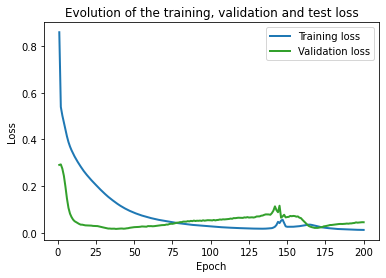

In [16]:
# plot the loss history
plot_loss(BM_reg_noexc.train_loss_history, BM_reg_noexc.val_loss_history)

In [17]:
# Check the benchmark models
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

0.016458112729014828
./content/model38.pth


In [18]:
print("The validation loss is (BM_noexc) {}".format(np.mean(BM_reg_noexc.val_loss_history[-20:])))

The validation loss is (BM_noexc) 0.04027568268220904


In [20]:
# Split conformal prediction 
alpha = 0.1

coverage_BM_noexc = []
size_BM_noexc = []
test_losses_BM_noexc = []
pi_BM_noexc = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI[0])
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

wsc_coverages_BM_noexc = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

print("The marginal coverage rate is (BM_noexc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM_noexc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM_noexc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM_noexc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))



100%|██████████| 100/100 [00:01<00:00, 71.13it/s]


The marginal coverage rate is (BM_noexc) 0.78
The conditional coverage rate is (BM_noexc) 0.6473015873015873
The average size is (BM_noexc) 0.592337718307972
The test loss is (BM_noexc) 0.1868955927533432


Then let's investigate the cases when the size of the calibration set is large (n_calib = 1000). When n_calib is large, a single test sample should not have much effect in changing the loss functions, hence ignoring the exchangeability between test samples and calibration samples may not invalidate marginal coverage rate.

In [ ]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set, 3000 for training, 1000 for choosing best model and calibration
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM_noexc])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM_noexc]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM_noexc): train (3000, 18), calibration (1000, 18), test (100, 18)


In [ ]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [ ]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (1000), test (100)


In [ ]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg_noexc = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [ ]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.54  took: 0.01s
Epoch 1 of 200, 17% 	 train_loss: 1.20  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 0.94  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.89  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 0.85  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 0.78  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 0.75  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 0.80  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 0.55  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.51  took: 0.02s
Epoch 1 of 200, 93% 	 train_loss: 0.64  took: 0.02s
val_loss = 0.56
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.60  took: 0.01s
Epoch 2 of 200, 17% 	 train_loss: 0.63  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.56  took: 0.02s
Epoch 2 of 200, 42% 	 train_loss: 0.55  took: 0.02s
Epoch 2 of 200, 51% 	 train_loss: 0.52  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 68% 	 t

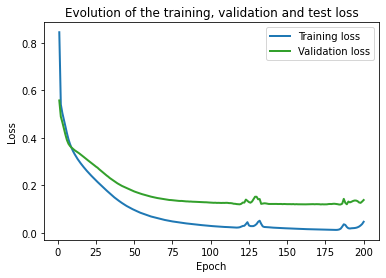

In [ ]:
# plot the loss history
plot_loss(BM_reg_noexc.train_loss_history, BM_reg_noexc.val_loss_history)

In [ ]:
# Check the benchmark models
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

0.11898752960117825
./content/model184.pth


In [ ]:
print("The validation loss is (BM_noexc) {}".format(np.mean(BM_reg_noexc.val_loss_history[-20:])))

The validation loss is (BM_noexc) 0.12834548215132793


In [ ]:
# Split conformal prediction 
alpha = 0.1

coverage_BM_noexc = []
size_BM_noexc = []
test_losses_BM_noexc = []
pi_BM_noexc = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI[0])
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

wsc_coverages_BM_noexc = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

print("The marginal coverage rate is (BM_noexc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM_noexc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM_noexc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM_noexc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))



100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The marginal coverage rate is (BM_noexc) 0.93
The conditional coverage rate is (BM_noexc) 0.9666666666666667
The average size is (BM_noexc) 1.07138704180717
The test loss is (BM_noexc) 0.09557244484713578
